In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

mpl.rcParams['pdf.fonttype'] = 42
%config InlineBackend.figure_format = 'retina'

In [ ]:
# define a function to calculate the min and max of the SEM
def cal_sem(x:np.array):
    return np.mean(x) - stats.sem(x, nan_policy='omit'), np.mean(x) + stats.sem(x, nan_policy='omit')

In [ ]:
data = pd.read_excel('../data/blood_prep.xlsx', header=None)

In [ ]:
# data.columns = ['Sample','CellType','Values','Unit','Test']
data.columns = ['Sample','CellType','Values','Unit']

In [ ]:
data

,Sample,CellType,Values,Unit
0,Veh10,CBC (smear review),NaN,NaN
1,Veh10,CBC mouse,NaN,NaN
2,Veh10,Small Blood Count - Bioresearch,NaN,NaN
3,Veh10,Leukocytes,2.7,G/l
4,Veh10,Erythrocytes,9.5,T/l
...,...,...,...,...
962,Veh2,Lymphocytes (absolute),775,/ul
963,Veh2,Monocytes (absolute),55,/ul
964,Veh2,Polychromasia,+g,NaN
965,Veh2,Reticulocytes (relative),3.73,%


In [ ]:
data = data.dropna().reset_index(drop=True)

In [ ]:
data.Values = data.Values.astype(float)

data['Conditions'] = data['Sample'].copy()
data.Conditions = data.Conditions.astype('category').cat.reorder_categories(['Uninj','Ctr','Veh10','V','Veh2','P Bcl-2','P Bcl-xL'])

In [ ]:
data['CT_unit'] = data.CellType.astype(str) + ' ' + data.Unit.astype(str)

In [ ]:
datas = {k:data[data.CellType == k].reset_index(drop=True) for k in data.CellType.unique()}

In [ ]:
list(sns.color_palette("Set2", 5).as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

In [ ]:
for c in ['Veh10','Ctr']:
    t = ['D1','D2','D3']
    if c == 'Ctr':
        t = t[1:]
    for i in t:
        a = datas['Thrombocytes'][datas['Thrombocytes'].Conditions == c].Values
        b = datas['Thrombocytes'][datas['Thrombocytes'].Conditions == i].Values
        print(c,i,stats.ttest_ind(a,b)[1]/5)

Veh10 D1 nan
Veh10 D2 nan
Veh10 D3 nan
Ctr D2 nan
Ctr D3 nan


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_77577/1322428573.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(c,i,stats.ttest_ind(a,b)[1]/5)


In [ ]:
for ct in ['Erythrocytes','Thrombocytes']:
    for c in ['V', 'P Bcl-2', 'P Bcl-xL']:
        if c.startswith('P'):
            i = 'Veh2'
        else:
            i = 'Veh10'
        a = datas[ct][datas[ct].Conditions == i].Values
        b = datas[ct][datas[ct].Conditions == c].Values
        print(ct,c,i,stats.ttest_ind(a,b)[1]/5)

Erythrocytes V Veh10 0.08560269928565752
Erythrocytes P Bcl-2 Veh2 0.04327750005998998
Erythrocytes P Bcl-xL Veh2 0.00011542231833044224
Thrombocytes V Veh10 0.07167546266053315
Thrombocytes P Bcl-2 Veh2 0.1178909320002129
Thrombocytes P Bcl-xL Veh2 0.07068479883374881


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_77577/4200510721.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v.Conditions = v.Conditions.cat.remove_unused_categories()
/Users/pax/miniconda3/envs/bh_img/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_77577/4200510721.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Uninj','NT','Veh10','V','Veh2','P Bcl-xL'], fontsize=11, rotation=90)
/var/folders/pg/_gfvz

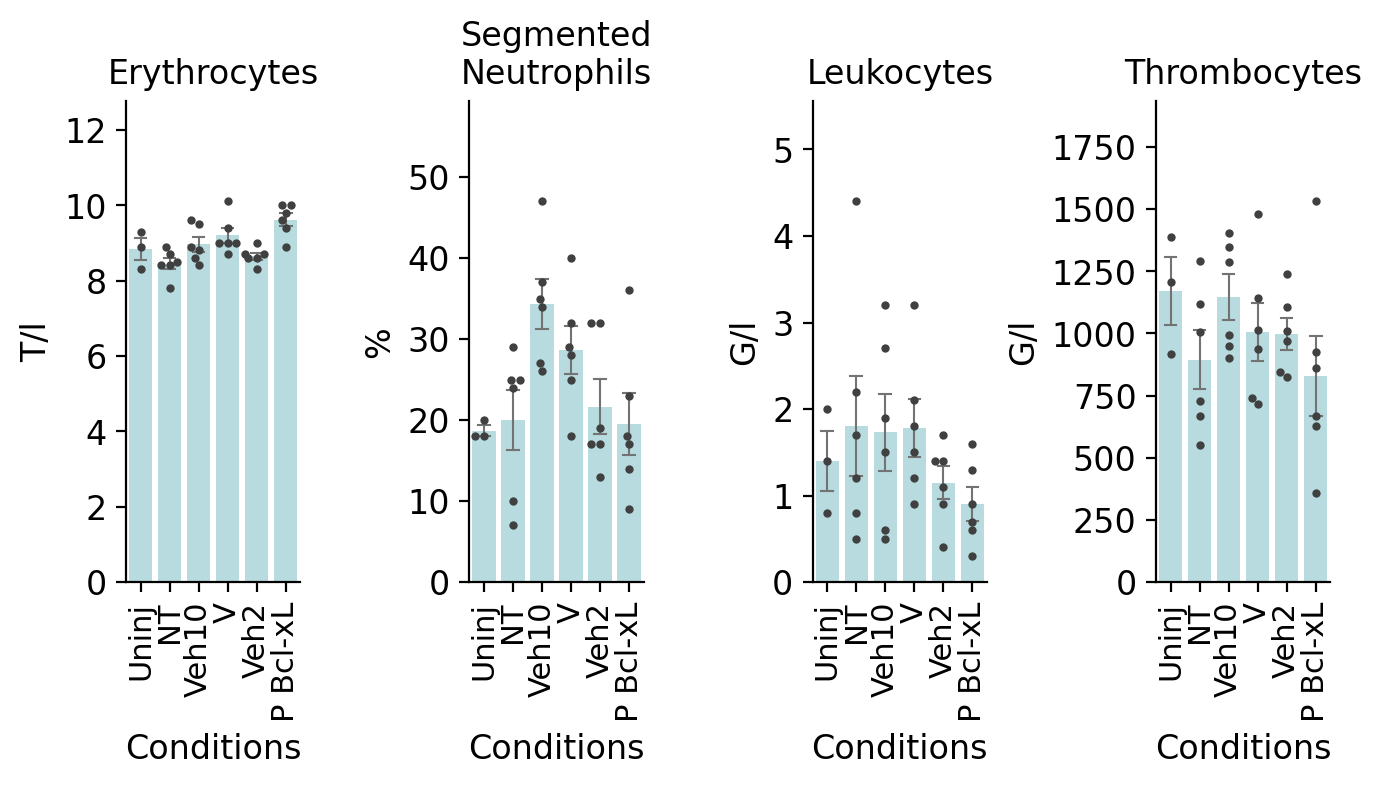

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(4.5*1.5,3))
axes = axes.ravel()
fig.tight_layout(w_pad=3, h_pad=3.5)
for ax,k,v in zip(axes,
                  ['Erythrocytes','Segmented neutrophils','Leukocytes','Thrombocytes'],
                  list(map(datas.get,['Erythrocytes','Segmented neutrophils','Leukocytes','Thrombocytes']))):
    
    v = v[v.Conditions != 'P Bcl-2']
    v.Conditions = v.Conditions.cat.remove_unused_categories()
    sns.barplot(x='Conditions', y='Values', data=v, errorbar=cal_sem,
                capsize=.4,err_kws={"color": "0.45", "linewidth": 0.75}, ax=ax, color='#b0e0e6')
    sns.swarmplot(x='Conditions', y='Values', data=v, ax=ax, color='0.25', size=3)
    
    max_val = v.Values.max() + v.Values.max()*0.1
    ax.set_xlabel('Conditions', fontsize=12)
    ax.set_ylabel(v.Unit.unique()[0], fontsize=12)
    ax.set_ylim(0, max_val+max_val*0.15)
    ax.set_xticklabels(['Uninj','NT','Veh10','V','Veh2','P Bcl-xL'], fontsize=11, rotation=90)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_title('\n'.join(k.title().split(' '))
                    if ' ' in k else k.title(), fontsize=12)
    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/blood_manu.pdf', dpi=300, bbox_inches='tight')